# Demonstration 5: Free Choice Premium

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sisyphus.envs import FreeChoice
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Model-Free Temporal Difference Learning

100%|██████████| 500/500 [07:47<00:00,  1.06it/s]


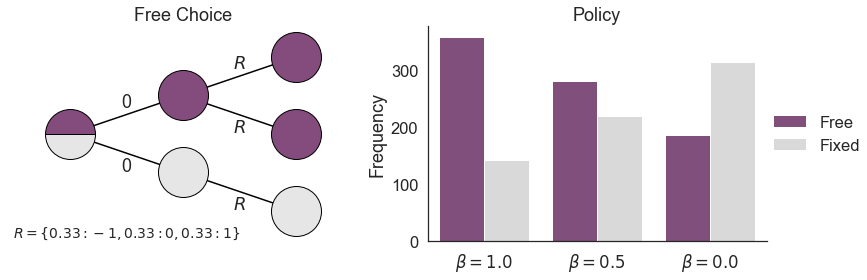

In [2]:
from pandas import DataFrame
from sisyphus.mdp import ModelFree
from sisyphus.mdp._misc import softmax
from sisyphus.viz import plot_free_choice
from tqdm import tqdm
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Simulation parameters.
n_agents = 500
betas = [1.0, 0.5, 0.0]
rewards = [-1,0,1]

## Define exploration schedule.
schedule = np.logspace(0,1,100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize environment.
gym = FreeChoice(rewards=rewards)

data = []
for beta in betas:
    
    ## Initialize agent.
    agent = ModelFree('betamax', eta=0.1, gamma=1, beta=beta)
    
    for _ in tqdm(range(n_agents)):
        
        ## Solve for Q-values.
        agent = agent.fit(gym, schedule=schedule, overwrite=True)
        
        ## Compute choice likelihood.
        theta = softmax(agent.Q[:2] * schedule[-1])
        
        ## Store results.
        data.append( dict(beta=beta, theta=theta[0], pi=agent.pi[1]) )

## Convert to DataFrame.
data = DataFrame(data)
    
## Fix labels.
data['Choice'] = np.where(data.pi==1, 'Free', 'Fixed')
data.to_csv('figures/05_choice.csv', index=False)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
## Initialize figure.
fig, axes = plt.subplots(1,2,figsize=(12,4))
palette = ['#834c7d','0.85']

## Plot environment.
plot_free_choice(axes[0], edge_labels=True)
axes[0].set_title('Free Choice')

## Plot simulation results.
sns.countplot('beta', hue='Choice', data=data, order=betas, 
              palette=palette, saturation=0.9, ax=axes[1])
axes[1].set(xticklabels=[r'$\beta=%0.1f$' %beta for beta in betas], xlabel='',
             ylabel='Frequency', title='Policy')
axes[1].legend(loc=7, bbox_to_anchor=(1.3,0.5), frameon=False, borderpad=0)

## Clean up.
sns.despine(ax=axes[1])
plt.tight_layout()
plt.savefig('figures/05_choice.png', dpi=180)